In [59]:
import numpy as np
import math as mp
import pandas as pd
import matplotlib.pyplot as plt

In [60]:
gamma = 1
eta = 2
sigma = 5
beta_hh = 0.99
r = 0.01
beta = 1 /( 1.0 +r)
beta1 =1/( (1.0 +r* np.exp(30/(36.5*0.9)))) 
W = 1
power = (1+eta)/(-gamma-eta)
mu = 0

/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_31855/2291322681.py:6: RuntimeWarning: divide by zero encountered in log
  N = -(data_tau) - 1/np.log(beta*c)
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_31855/2291322681.py:7: RuntimeWarning: divide by zero encountered in log
  tau1= -1/np.log(beta*c) - N
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_31855/2291322681.py:9: RuntimeWarning: divide by zero encountered in log
  tau2= -1/np.log(beta1*c) - N


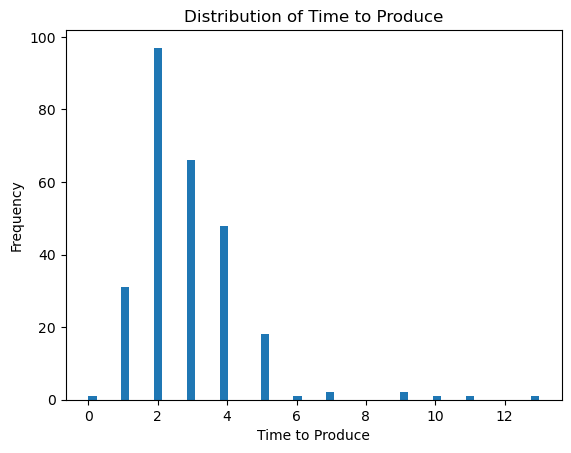

In [61]:
data=pd.read_csv('APP_data_usa_goods.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
data_tau=(data['invtCogsRatio']* 36.5/(30*0.1))
tau_diff = np.zeros(( 1000,1))
i = 0
for c in np.linspace(0, 0.99, 1000): 
    N = -(data_tau) - 1/np.log(beta*c) 
    tau1= -1/np.log(beta*c) - N
    tau1[tau1<0] = 0     
    tau2= -1/np.log(beta1*c) - N
    tau2[tau2<0] = 0    
    tau_diff[i] = np.mean(np.abs(tau1-tau2))
    i = i+1

min_val = np.min(np.abs(tau_diff-1))
argmins = np.where(np.abs(tau_diff-1) == min_val)[0]
argmins
c_list = np.linspace(0, 0.99, 1000)
c=c_list[argmins]
N=-data_tau - 1/np.log(beta*c) 
tau= -1/np.log(beta*c) - N
tau[tau<0] = 0  
tau_floor = np.floor(tau)
tau_ceil = np.ceil(tau)
tprod_ceil=  (beta*c)**tau_ceil * (tau_ceil + N)
tprod_floor=  (beta*c)**tau_floor * (tau_floor + N)
tau[(tprod_ceil-tprod_floor)>0] = tau_ceil[(tprod_ceil-tprod_floor)>0]
tau[(tprod_ceil-tprod_floor)<0] = tau_floor[(tprod_ceil-tprod_floor)<0]
tau[tau<0] = 0  
tprod = (beta*c)**tau * (tau + N)
plt.hist(tau, bins = 55, alpha=1, label='tau_noise')
plt.xlabel('Time to Produce')
plt.ylabel('Frequency')
plt.title('Distribution of Time to Produce')
plt.show()
tau = np.array(tau, dtype=int)

In [62]:
r_arrange = np.linspace(0.007, 0.011, 100)
P = np.zeros((20, 100))
W = np.ones((20, 100))
C = P
shock = 0.8
k=0
tau_list = {}
index_diff_list = {}
for r in r_arrange: 
    beta_org = (1 / (1 + 0.01))*c
    tau= -1/np.log(beta_org) - N
    tau[tau<0] = 0  
    tau_floor = np.floor(tau)
    tau_ceil = np.ceil(tau)
    tprod_ceil=  beta_org**tau_ceil * (tau_ceil + N)
    tprod_floor=  beta_org**tau_floor * (tau_floor + N)
    tau[(tprod_ceil-tprod_floor)>0] = tau_ceil[(tprod_ceil-tprod_floor)>0]
    tau[(tprod_ceil-tprod_floor)<0] = tau_floor[(tprod_ceil-tprod_floor)<0]
    tau[tau<0] = 0 
    tprod1=  np.array(beta_org**tau * (tau + N) )  
    P0 = (np.sum(1/(tprod1)**(1-sigma)))**(1/(1-sigma)) 

    beta_rep = (1 / (1 + r))*c
    tau_rep= -1/np.log(beta_rep) - N
    tau_rep[tau_rep<0] = 0  
    tau_rep_floor = np.floor(tau_rep)
    tau_rep_ceil = np.ceil(tau_rep)
    tprod_ceil=  beta_rep**tau_rep_ceil * (tau_rep_ceil + N)
    tprod_floor=  beta_rep**tau_rep_floor * (tau_rep_floor + N)
    tau_rep[(tprod_ceil-tprod_floor)>0] = tau_rep_ceil[(tprod_ceil-tprod_floor)>0]
    tau_rep[(tprod_ceil-tprod_floor)<0] = tau_rep_floor[(tprod_ceil-tprod_floor)<0]
    tau_rep[tau_rep<0] = 0 
    tprod_rep=  np.array(beta_rep**tau_rep * (tau_rep + N) )  
    P1 = (np.sum(1/(tprod_rep)**(1-sigma)))**(1/(1-sigma)) 

    P[0, k] = P0
    C[0,k] = P0**power
    tau_list[k] = np.array(tau_rep)
    tau = tau.sort_values()
    tau_rep = tau.sort_values()
    diff = tau-tau_rep
    index_diff=tau_rep[diff !=0].index
    index_diff_list[k] = np.sum(index_diff!=0)
    
    C_0 = P0**power
    P_0 = P0

    for j in range(0, int(np.max(tau_rep)) + 1):
        tau1_temp = pd.Series(tau[tau > j])
        tau2_temp = pd.Series(tau_rep[tau_rep <= j])

        tau1_temp_df = tau1_temp.to_frame(name='t')
        tau1_temp_df['source'] = 'org'

        tau2_temp_df = tau2_temp.to_frame(name='t')
        tau2_temp_df['source'] = 'rep'

        t_temp = pd.concat([tau1_temp_df, tau2_temp_df])

        dup_indices = t_temp.index[t_temp.index.duplicated(keep=False)].unique()

        keep_rows = []

        for i in dup_indices:
            rows = t_temp.loc[[i]]
            N_temp = N.loc[[i]]
            t_org = rows[rows['source'] == 'org']['t'].values[0]
            t_rep = rows[rows['source'] == 'rep']['t'].values[0]

            tprod_org_temp = beta_org**t_org * (t_org + N_temp)
            tprod_rep_temp = beta_rep**t_rep * (t_rep + N_temp)
            if i ==j:
                tprod_rep_temp = shock*beta_rep**t_rep * (t_rep + N_temp)

            # Keep only the row with the higher value
            if tprod_org_temp.values >= tprod_rep_temp.values:
                keep_rows.append(rows[rows['source'] == 'org'])
            else:
                keep_rows.append(rows[rows['source'] == 'rep'])

        # Drop all duplicates first
        t_temp = t_temp[~t_temp.index.isin(dup_indices)]

        # Add back only the best ones
        if keep_rows:
            t_temp = pd.concat([t_temp] + keep_rows)

        

        # Step 1: Add matching N values
        t_temp['N'] = N.loc[t_temp.index].values  # will align correctly by NAICS6 index

        # Step 2: Compute t_prod using vectorized logic
        beta_vec = t_temp['source'].map({'org': beta_org, 'rep': beta_rep})
        A_vec = np.where((t_temp['source'] == 'rep') & (t_temp['t'] == j), shock, 1.0)
        t_temp['A'] = A_vec
        t_temp['t_prod'] = A_vec * beta_vec ** t_temp['t'] * (t_temp['t'] + t_temp['N'])
        
        tprod_temp = t_temp['t_prod'].values

        full_tau_df = pd.Series(tau).to_frame(name='t')
        full_tau_df['source'] = 'org'
        full_tau_df.index = tau.index
        full_tau_df['t_prod'] = beta_org**full_tau_df['t'] * (full_tau_df['t'] + N) 
                # Step 3: Build common index (union of both)

        # Step 1: Compute 1 / t_prod for both DataFrames
        full_tau_df['inv_p_ss'] = 1 / full_tau_df['t_prod']** (1 - sigma)
        t_temp['inv_P_1R'] = (1 / t_temp['t_prod']) ** (1 - sigma)

        p_ss_by_t = full_tau_df.groupby('t')['inv_p_ss'].sum()
        P_1R_by_t = t_temp.groupby('t')['inv_P_1R'].sum()
        all_t_vals = sorted(set(p_ss_by_t.index).union(P_1R_by_t.index))

        p_ss_by_t = p_ss_by_t.reindex(all_t_vals, fill_value=0)
        P_1R_by_t = P_1R_by_t.reindex(all_t_vals, fill_value=0)

        p_ss_arr = p_ss_by_t.to_numpy()
        P_1R_arr = P_1R_by_t.to_numpy()     

        
            # Recompute P_1 and C_1 using the solution
        term = mu * p_ss_arr + (1 - mu) * P_1R_arr 
        P_1 = np.sum(term)**( 1 / (1 - sigma))
        C_1 = (P_1 / 1)**power
            # Store results
        P[j + 1, k] = P_1
        W[j + 1, k] = 1
        C[j + 1, k] = C_1
        P_0  = P_1
        C_0 = C_1
    k += 1


In [68]:
k=0
deviation_gap = np.zeros((100, 1))
for r in r_arrange: 
    P_temp = P[1:,k]
    W_temp = W[1:,k]
    C_temp = C[1:,k]
    P_temp_no_zeros = P_temp[P_temp != 0]
    W_temp_no_zeros = W_temp[W_temp != 0]
    C_temp_no_zeros = C_temp[C_temp != 0]
    Y = np.zeros((len(P_temp_no_zeros), 1))
    
    Y[0] = (C_temp_no_zeros[0])**power / (C_temp_no_zeros[0])**power
    Y[1:,0] = (C_temp_no_zeros[1:])**power / (C_temp_no_zeros[0])**power
    wage_inflation = np.zeros(len(P_temp_no_zeros)-1)

    for i in range(len(P_temp_no_zeros)-1):
        P_0 = P_temp_no_zeros[i]
        P_1 = P_temp_no_zeros[i+1]
        wage_inflation[i] =    P_1/P_0

    deviation_gap[k] = np.sum((Y - 1 )**2)  
    k = k+1

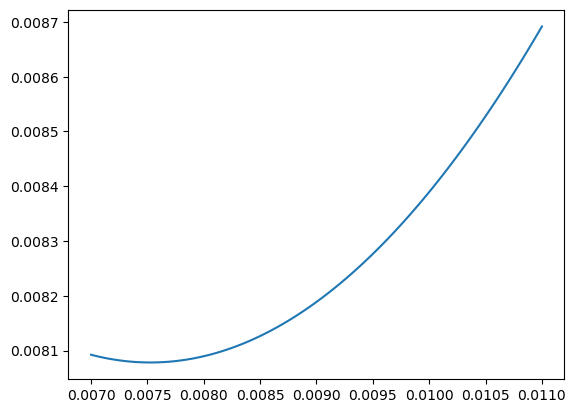

In [69]:
plt.plot(r_arrange, deviation_gap)

In [70]:
argmins_gap = np.where(deviation_gap == np.min(deviation_gap))[0]


In [71]:
r_arrange[argmins_gap]

array([0.00752525])

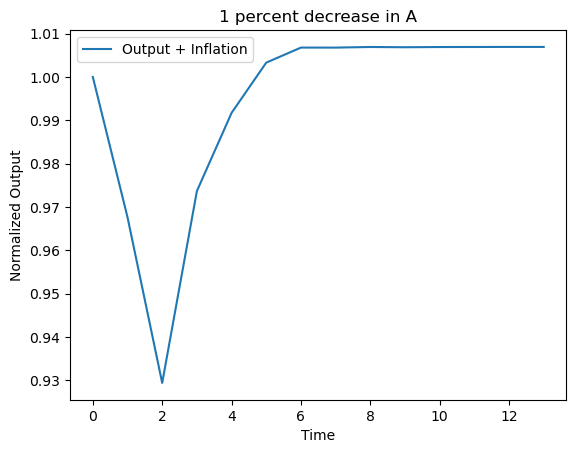

In [72]:
C_mask = C[1:,argmins_gap]
C_mask_no_zeros = C_mask[C_mask != 0]

plt.plot( (C_mask_no_zeros)/C_mask_no_zeros[0], label='Output + Inflation')

plt.legend(['Output + Inflation', 'Output', 'Inflation'])
plt.title('1 percent decrease in A')
plt.xlabel('Time')
plt.ylabel('Normalized Output') 
plt.show()